In [68]:
import pandas as pd
import numpy as np
from utils import charas
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [88]:
OOS_start = 19870101
OOS_end = 20161231

def calculate_R2(model, _type, portfolio = True):
    if portfolio:
        portfolio_ret = pd.read_pickle('data/portfolio_ret.pkl')
    else:
        raise Exception('Unrealized Function')
    oos_ret = portfolio_ret.loc[(portfolio_ret['DATE'] >= OOS_start) & (portfolio_ret['DATE'] <= OOS_end)]
    
    output_path = f'results/{_type}/{model}_{_type}.csv'
    model_output = pd.read_csv(output_path)
    
    residual_square = (oos_ret.set_index('DATE') - model_output.set_index('DATE'))**2
    residual_square = (1 - (residual_square == np.inf) * 1.0) * residual_square # drop Inf outliers
    
    total_square = oos_ret.set_index('DATE')**2
    total_square = (1 - (total_square == np.inf) * 1.0) * total_square # drop Inf outliers
    
    return 1 - np.sum(residual_square.values)/np.sum(total_square.values)

In [100]:
models = [f'FF_{i+1}' for i in range(6)] + [f'PCA_{i+1}' for i in range(6)] + [f'IPCA_{i+1}' for i in range(6)] + [f'CA0_{i+1}' for i in range(6)] + [f'CA1_{i+1}' for i in range(6)] + [f'CA2_{i+1}' for i in range(6)] + [f'CA3_{i+1}' for i in range(6)]

In [101]:
inference_R2 = []
predict_R2 = []
for mod in models:
    try:
        inference_R2.append(calculate_R2(mod, 'inference'))
        predict_R2.append(calculate_R2(mod, 'predict'))
    except:
        inference_R2.append(np.nan)
        predict_R2.append(np.nan)

In [143]:
R2_df = pd.DataFrame([inference_R2, predict_R2], columns = models, index=['inference', 'predict']).fillna(0.6)

In [159]:
def plot_R2(R2_df, _type):
    labels = ['K=1', 'K=2', 'K=3', 'K=4', 'K=5', 'K=6']

    FF_R2 = R2_df.loc[_type][[f'FF_{i+1}' for i in range(6)]].values
    FF_R2 = FF_R2 * (FF_R2 >= 0)

    PCA_R2 = R2_df.loc[_type][[f'PCA_{i+1}' for i in range(6)]].values
    PCA_R2 = PCA_R2 * (PCA_R2 >= 0)

    # IPCA_R2 = R2_df.loc[_type][[f'IPCA_{i+1}' for i in range(6)]].values
    # IPCA_R2 = IPCA_R2 * (IPCA_R2 >= 0)

    CA0_R2 = R2_df.loc[_type][[f'CA0_{i+1}' for i in range(6)]].values
    CA0_R2 = CA0_R2 * (CA0_R2 >= 0)

    # CA1_R2 = R2_df.loc[_type][[f'CA1_{i+1}' for i in range(6)]].values
    # CA1_R2 = CA1_R2 * (CA1_R2 >= 0)

    # CA2_R2 = R2_df.loc[_type][[f'CA2_{i+1}' for i in range(6)]].values
    # CA2_R2 = CA2_R2 * (CA2_R2 >= 0)

    CA3_R2 = R2_df.loc[_type][[f'CA3_{i+1}' for i in range(6)]].values
    CA3_R2 = CA3_R2 * (CA3_R2 >= 0)

    x = np.arange(0, len(labels)*3, 3)  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(15, 5))
    rects1 = ax.bar(x - 1*width, FF_R2, width, label='FF')
    rects2 = ax.bar(x - 0*width, PCA_R2, width, label='PCA')
    # rects3 = ax.bar(x - 0*width, IPCA_R2, width, label='IPCA')
    rects4 = ax.bar(x + 1*width, CA0_R2, width, label='CA0')
    # rects5 = ax.bar(x + 1*width, CA1_R2, width, label='CA1')
    # rects6 = ax.bar(x + 2*width, CA2_R2, width, label='CA2')
    rects7 = ax.bar(x + 2*width, CA3_R2, width, label='CA3')


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('R^2')
    if _type == 'inference':
        ax.set_title('R total')
    else:
        ax.set_title('R predict')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()


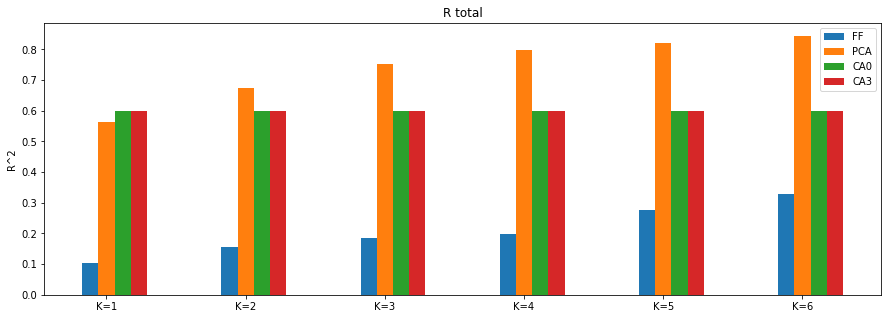

In [160]:
plot_R2(R2_df, 'inference')

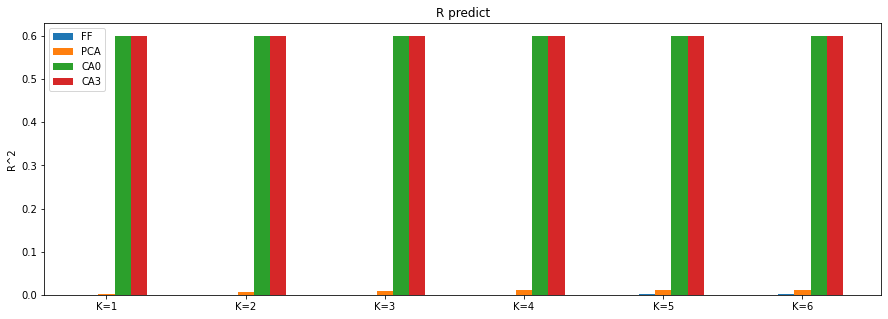

In [161]:
plot_R2(R2_df, 'predict')

In [44]:
def alpha_plot(model, _type, portfolio = True):
    if not portfolio:
        raise Exception('Unrealized Function')
    
    portfolio_ret = pd.read_pickle('data/portfolio_ret.pkl')
    oos_result = portfolio_ret.loc[(portfolio_ret['DATE'] >= OOS_start) & (portfolio_ret['DATE'] <= OOS_end)].set_index('DATE')
    
    output_path = f'results/{_type}/{model}_{_type}.csv'
    inference_result = pd.read_csv(output_path)
    inference_result = inference_result.set_index('DATE')
    
    pricing_error_analysis = []
    for col in charas:
        raw_return = oos_result[col].mean()
        error = oos_result[col] - inference_result[col]
        alpha = error.mean()
        t_stat = abs(error.mean()/error.std()) * np.sqrt(oos_result.shape[0])
        pricing_error_analysis.append([raw_return, alpha, t_stat])

    pricing_error_analysis = pd.DataFrame(pricing_error_analysis, columns = ['raw ret', 'alpha', 't_stat'], index=charas)
    
    lower_point = min(np.min(pricing_error_analysis['raw ret']), np.min(pricing_error_analysis['alpha'])) * 1.15
    upper_point = max(np.max(pricing_error_analysis['raw ret']), np.max(pricing_error_analysis['alpha'])) * 1.15

    significant_mask = pricing_error_analysis['t_stat'] > 3

    plt.scatter(pricing_error_analysis.loc[significant_mask]['raw ret'], pricing_error_analysis.loc[significant_mask]['alpha'], marker='^', color='r', alpha=0.6, label=f'#Alphas(t>3.0)={np.sum(significant_mask*1.0)}')
    plt.scatter(pricing_error_analysis.loc[~significant_mask]['raw ret'], pricing_error_analysis.loc[~significant_mask]['alpha'], marker='o', color='b', alpha=0.6, label=f'#Alphas(t<3.0)={94-np.sum(significant_mask*1.0)}')
    plt.plot(np.linspace(lower_point, upper_point, 10), np.linspace(lower_point, upper_point, 10), color='black')

    plt.ylabel('Alpha')
    plt.xlabel('Raw Return')
    plt.legend()

    plt.title(model)
    plt.show()

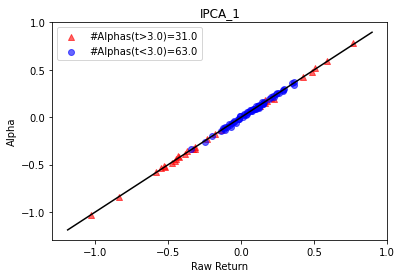

In [145]:
alpha_plot('IPCA_1', 'inference')

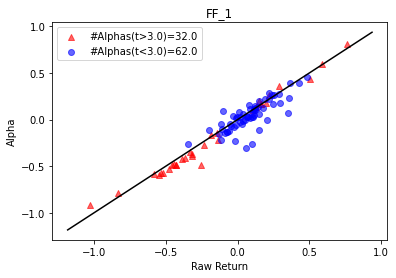

In [46]:
alpha_plot('FF_1', 'inference')